In [1]:
!pip install git+https://github.com/fastai/fastcore > /dev/null
!pip install git+https://github.com/fastai/fastai2 > /dev/null
!pip install iterative-stratification > /dev/null
!pip install timm -U

  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-5zvhodcj
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-82fs2ri6
     |████████████████████████████████| 207 kB 10.8 MB/s eta 0:00:01


https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/05_EfficientNet_and_Custom_Weights.ipynb

In [3]:
from fastai2.vision.all import *
import torch
from timm import create_model
net = create_model('efficientnet_b3a', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra-a5e2fbc7.pth" to /root/.cache/torch/checkpoints/efficientnet_b3_ra-a5e2fbc7.pth


In [6]:
tfms = [[PILImage.create], [parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]


In [10]:
items = get_image_files(Path('./dataset/'))

In [28]:
split_idx = GrandparentSplitter(valid_name='val')(items)
dsets = Datasets(items, tfms, splits=split_idx)
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=200)

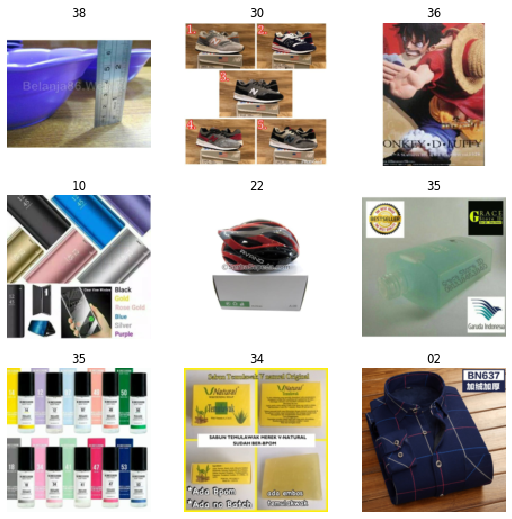

In [29]:
dls.show_batch()

In [18]:
# model darii timm itu generator, jadi create_body nya fastai harus di"modif" sesuai dengan arch-nya, dimana butuh generator.

def create_timm_body(arch:str, pretrained=True, cut=None):
    model = create_model(arch, pretrained=pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [19]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

In [20]:
nf = num_features_model(nn.Sequential(*body.children())) * (2); nf # ubah 3072 input di head nya. karena setelah di concat pooling kan jadi gak tau berapa output buat classnya 

3072

In [21]:
head = create_head(nf, dls.c)

In [22]:
model = nn.Sequential(body, head)

In [23]:
apply_init(model[1], nn.init.kaiming_normal_)

In [30]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=accuracy)

In [31]:
learn.freeze()
learn.summary()

Sequential (Input shape: ['200 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               200 x 40 x 64 x 64   1,080      False     
________________________________________________________________
BatchNorm2d          200 x 40 x 64 x 64   80         True      
________________________________________________________________
SwishMe              200 x 40 x 64 x 64   0          False     
________________________________________________________________
Conv2d               200 x 40 x 64 x 64   360        False     
________________________________________________________________
BatchNorm2d          200 x 40 x 64 x 64   80         True      
________________________________________________________________
SwishMe              200 x 40 x 64 x 64   0          False     
________________________________________________________________
AdaptiveAvgPool2d    200 x 40 x 1 x 1     0          False     
________________________________________________

In [ ]:
learn.lr_find(suggestions=True)


In [ ]:
learn.fit_one_cycle(5, slice(3e-2))
                             

In [ ]:
learn.save('efnet-stage1')


In [ ]:

learn.unfreeze()
learn.lr_find(suggestioin=True)


In [ ]:

learn.fit_one_cycle(5, 1e-4)